# **Testosterone-Deficiency Prediction**

## 1. Import Libraries

In [370]:
import pandas as pd
import numpy as np
import seaborn as sns
import torch as t
import torch.nn as nn
import torch.nn.functional as F
from scipy.stats import randint
import matplotlib.pyplot as plt
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
import pickle

# Data
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Model
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Evaluation & Tuning
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

plt.style.use('ggplot')

## 2. Load Dataset

In [6]:
data = pd.read_excel('/content/ptestost.xlsx')

In [7]:
data.sample(5)

,Age,DM,TG,HT,HDL,AC,T
3139,71,1,122,1,51.0,88.0,1
2910,59,0,257,1,44.0,111.0,1
3392,67,1,87,1,43.0,108.0,1
2356,59,1,118,1,43.0,87.0,0
1281,59,1,252,0,37.0,99.0,0


In [8]:
print(f'Total number of records: {data.shape[0]}')
print(f'Total number of features: {data.shape[1]}')

Total number of records: 3397
Total number of features: 7


## 3. Data Quality Checks

### 3.1. Check Data type

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3397 entries, 0 to 3396
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Age     3397 non-null   int64  
 1   DM      3397 non-null   int64  
 2   TG      3397 non-null   int64  
 3   HT      3397 non-null   int64  
 4   HDL     3397 non-null   float64
 5   AC      3397 non-null   float64
 6   T       3397 non-null   int64  
dtypes: float64(2), int64(5)
memory usage: 185.9 KB


### 3.2. Check Missing values

In [10]:
data.isnull().sum()

Age    0
DM     0
TG     0
HT     0
HDL    0
AC     0
T      0
dtype: int64

### 3.3. Check for Duplicate rows

In [11]:
print(f'The number of duplicated rows: {data.duplicated().sum()}')
duplicate_rows = data[data.duplicated()]
duplicate_rows

The number of duplicated rows: 7


,Age,DM,TG,HT,HDL,AC,T
38,60,1,71,0,47.0,88.0,0
258,60,1,135,0,42.0,97.0,0
498,54,0,112,0,38.0,90.0,0
980,61,0,141,1,38.0,100.0,0
1460,46,0,43,0,61.0,69.0,0
2149,47,1,66,0,38.0,94.0,0
2954,56,1,217,1,40.0,106.0,1


### 3.4. Check for Unique value count

In [12]:
data.nunique()

Age     41
DM       2
TG     406
HT       2
HDL     82
AC      81
T        2
dtype: int64

### 3.5.  Check Statistics of data

In [13]:
data.describe()

,Age,DM,TG,HT,HDL,AC,T
count,3397.000000,3397.000000,3397.000000,3397.000000,3397.000000,3397.000000,3397.000000
mean,61.327348,0.388578,155.269650,0.511922,46.325493,98.916515,0.193112
std,10.072821,0.487499,88.840249,0.499931,10.960146,10.629471,0.394798
min,45.000000,0.000000,12.000000,0.000000,13.000000,43.000000,0.000000
25%,53.000000,0.000000,97.000000,0.000000,39.000000,92.000000,0.000000
50%,60.000000,0.000000,136.000000,1.000000,45.000000,98.000000,0.000000
75%,69.000000,1.000000,183.000000,1.000000,52.000000,105.000000,0.000000
max,85.000000,1.000000,980.000000,1.000000,116.000000,198.000000,1.000000


## 4. EDA - Univariate Analysis

Here are the features:
1. Age: Age of patients in years (considered within the range of 45-85 years).

2. Triglycerides (TG): Integer numbers representing levels in mg/dl.

3. Waist Circumference (WC): Waist circumference in centimeters (threshold commonly noted at 102cm in medical literature).

4. HDL: High-Density Lipoprotein levels represented by integer numbers in mg/dl.

5. Hypertension: Binary feature indicating presence (1) or absence (0) of hypertension.

6. Diabetes: Binary feature indicating presence (1) or absence (0) of diabetes.

The target variable, denoted as T, signifies Testosterone levels. According to medical literature, a deficiency is suggested when T<300 ng/dl.

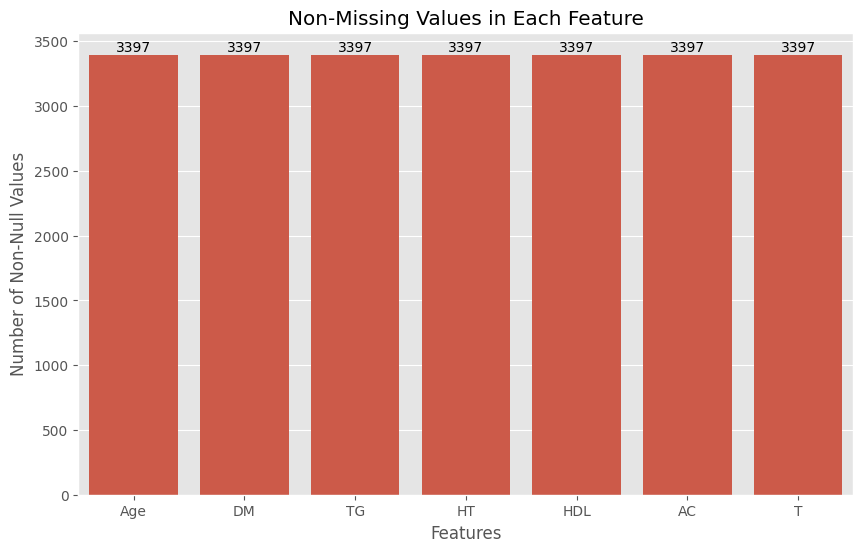

In [14]:
non_null_counts = data.count()

plt.figure(figsize=(10, 6))
sns.barplot(x = non_null_counts.index, y = non_null_counts.values)
plt.xlabel('Features')
plt.ylabel('Number of Non-Null Values')
plt.title('Non-Missing Values in Each Feature')


for i, count in enumerate(non_null_counts):
    plt.text(i, count + 0.1, str(count), ha='center', va='bottom')

plt.show()

In [15]:
unique_counts = data.nunique()
numerical = []
categorical = []
for feature in data.columns:
  if unique_counts[feature] == 2:
    categorical.append(feature)
  else:
    numerical.append(feature)
print(f'Categorical Features: {categorical}')
print(f'Numerical Features: {numerical}')

Categorical Features: ['DM', 'HT', 'T']
Numerical Features: ['Age', 'TG', 'HDL', 'AC']


### 4.1. Categorical Data


> **Pie Chart**





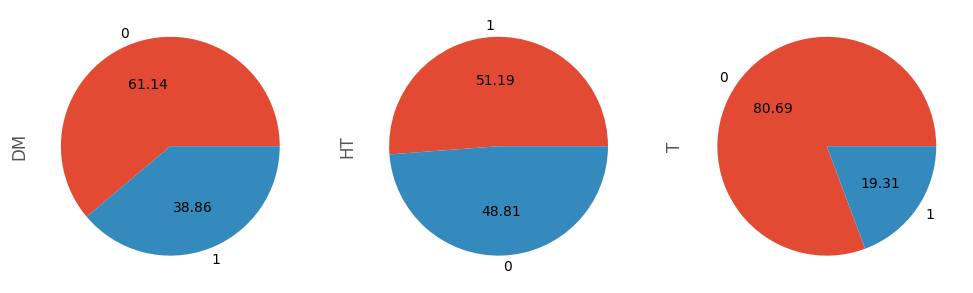

In [16]:
fig, axs = plt.subplots(1,3, figsize=(12, 6))

# pie chart for 'DM'
data['DM'].value_counts().plot(kind='pie', autopct='%.2f', ax=axs[0])

# pie chart for 'HT'
data['HT'].value_counts().plot(kind='pie', autopct='%.2f', ax=axs[1])

# pie chart for 'T'
data['T'].value_counts().plot(kind='pie', autopct='%.2f', ax=axs[2])

plt.show()

> **Bar Graph**

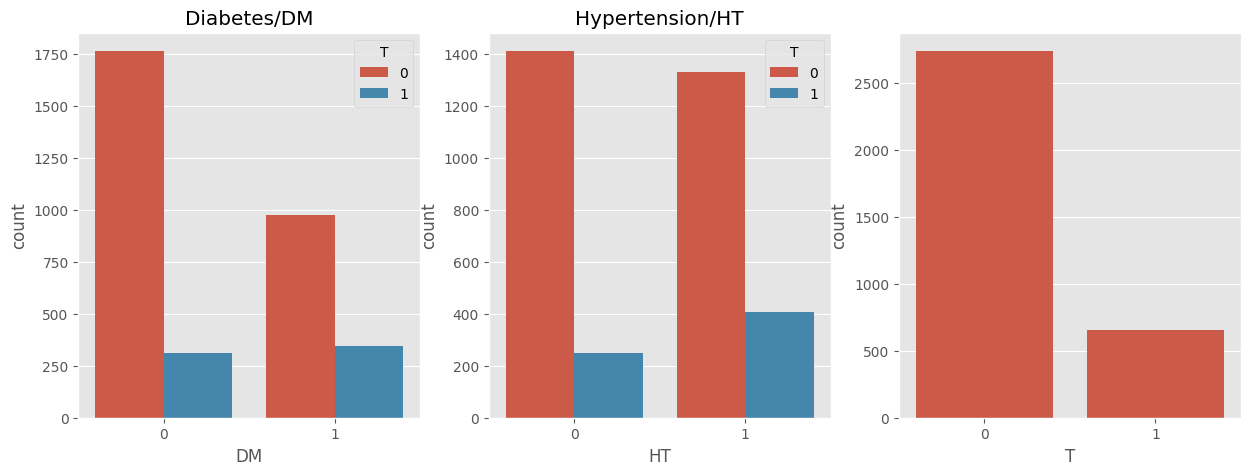

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

sns.countplot(x='DM', data=data, hue='T', ax=axs[0])
axs[0].set_title('Diabetes/DM')

sns.countplot(x='HT', data=data, hue='T', ax=axs[1])
axs[1].set_title('Hypertension/HT')

sns.countplot(x='T', data=data, ax=axs[2])

plt.show()

### 4.2. Numerical Data

> **Histogram with PDF**

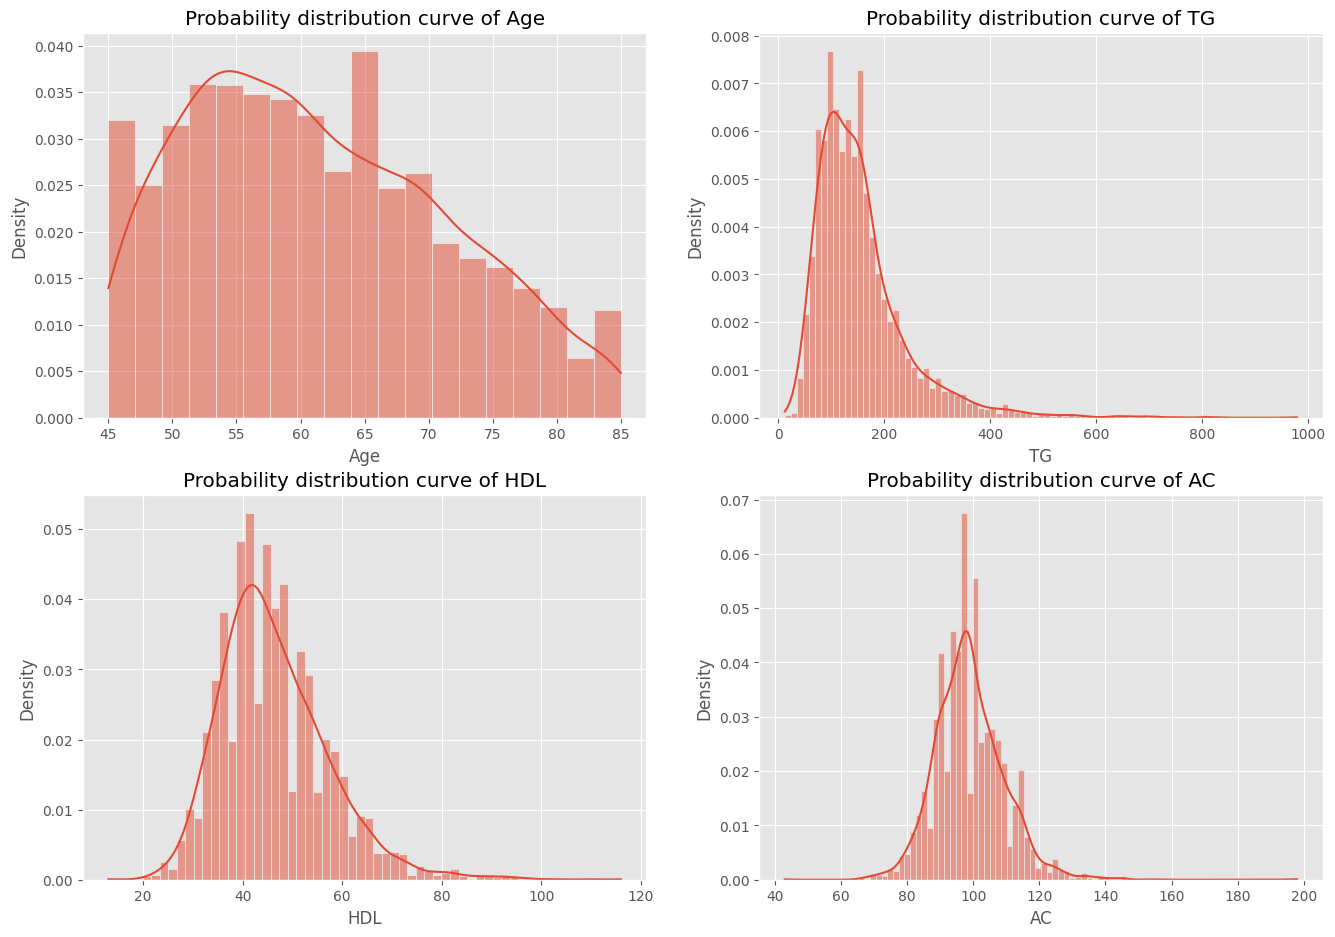

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(16, 11))

sns.histplot(data['Age'],kde=True, stat="density", ax=axs[0][0])
axs[0][0].set_title('Probability distribution curve of Age')

sns.histplot(data['TG'],kde=True, stat="density", ax=axs[0][1])
axs[0][1].set_title('Probability distribution curve of TG')

sns.histplot(data['HDL'],kde=True, stat="density", ax=axs[1][0])
axs[1][0].set_title('Probability distribution curve of HDL')

sns.histplot(data['AC'],kde=True, stat="density", ax=axs[1][1])
axs[1][1].set_title('Probability distribution curve of AC')
plt.show()

> **Box Plot**

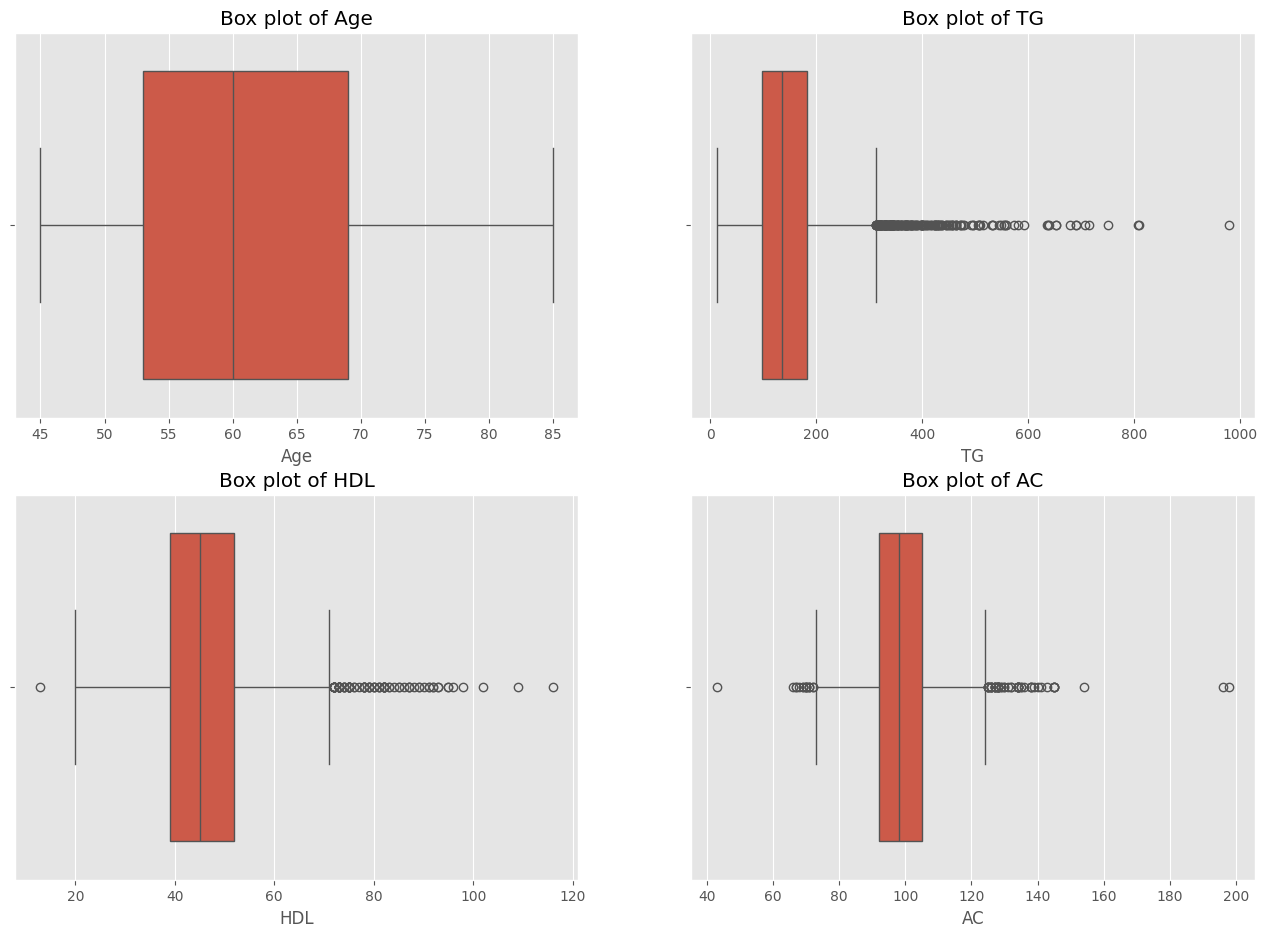

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(16, 11))

sns.boxplot(data['Age'],orient = 'h', ax=axs[0][0])
axs[0][0].set_title('Box plot of Age')

sns.boxplot(data['TG'],orient = 'h', ax=axs[0][1])
axs[0][1].set_title('Box plot of TG')

sns.boxplot(data['HDL'],orient = 'h', ax=axs[1][0])
axs[1][0].set_title('Box plot of HDL')

sns.boxplot(data['AC'],orient = 'h', ax=axs[1][1])
axs[1][1].set_title('Box plot of AC')
plt.show()

> **Indepth Statistics**

In [20]:
stats = {}
for feature in numerical:
  stats[feature] = {'Mean' : round(data[feature].mean(),2),
                    'Median': round(data[feature].median(),2),
                    'Mode': round(data[feature].mode()[0],2),
                    'Standard deviation': round(data[feature].std(),2),
                    'Coefficient of skewness': round(data[feature].skew(),2)}
for key, value in stats.items():
    print(f"{key}: {value}")

Age: {'Mean': 61.33, 'Median': 60.0, 'Mode': 53, 'Standard deviation': 10.07, 'Coefficient of skewness': 0.39}
TG: {'Mean': 155.27, 'Median': 136.0, 'Mode': 154, 'Standard deviation': 88.84, 'Coefficient of skewness': 2.34}
HDL: {'Mean': 46.33, 'Median': 45.0, 'Mode': 41.0, 'Standard deviation': 10.96, 'Coefficient of skewness': 1.0}
AC: {'Mean': 98.92, 'Median': 98.0, 'Mode': 98.0, 'Standard deviation': 10.63, 'Coefficient of skewness': 0.9}


## 5. EDA - Bivariate analysis

> **Correlation**

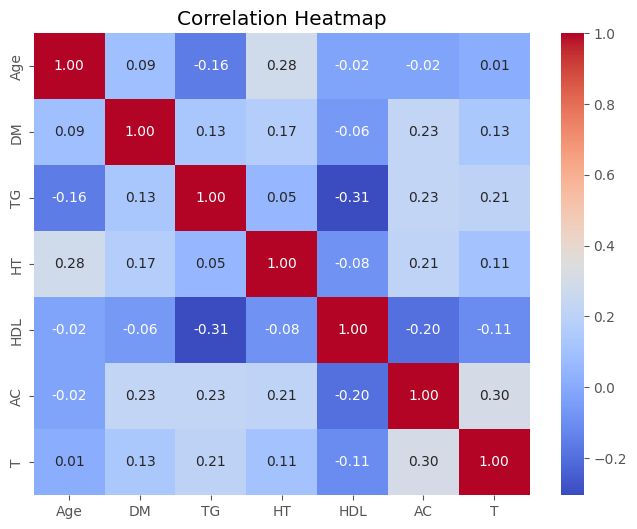

In [21]:
corr = data.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

### 5.1. Data type oriented Analysis

#### 5.1.1. Numerical v/s Numerical

> **Scatter plots**

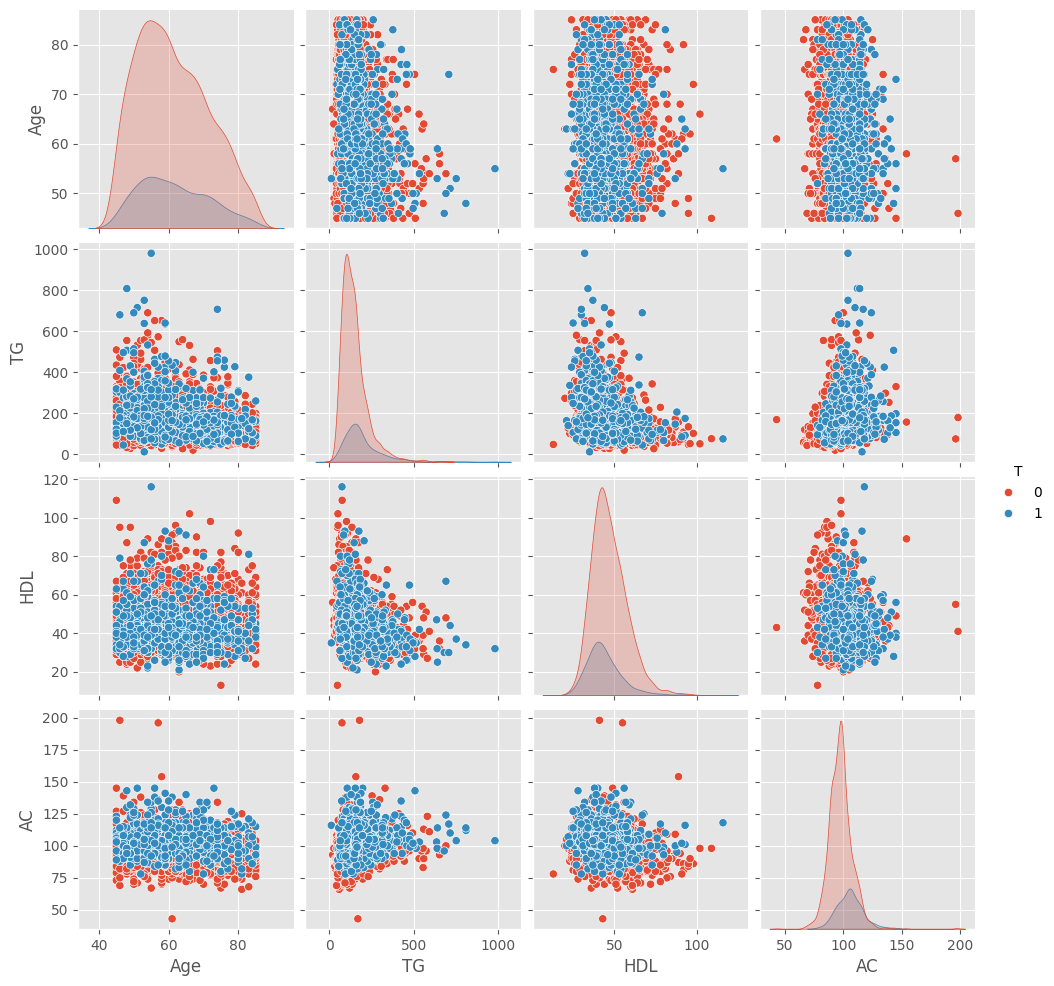

In [22]:
sns.pairplot(data[numerical+['T']], hue = 'T')

#### 5.1.2. Numerical v/s Categorical

> **Bar graph**

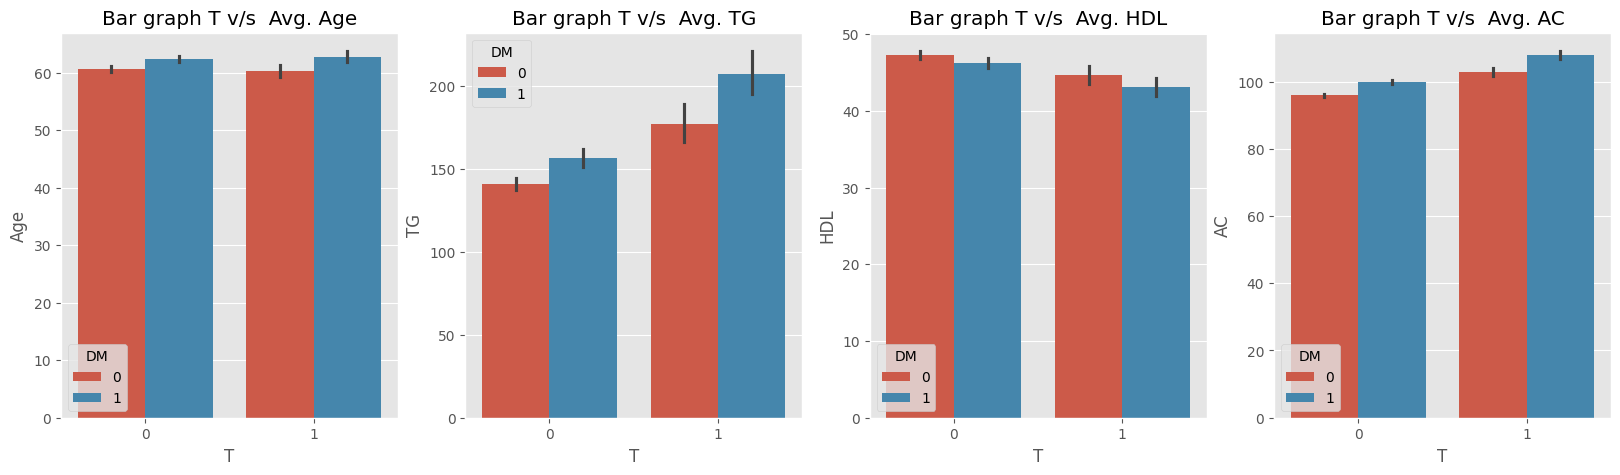

In [23]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

sns.barplot(data, x = 'T', y = 'Age', hue = 'DM', ax = axs[0])
axs[0].set_title('Bar graph T v/s  Avg. Age')

sns.barplot(data, x = 'T', y = 'TG', hue = 'DM', ax = axs[1])
axs[1].set_title('Bar graph T v/s  Avg. TG')

sns.barplot(data, x = 'T', y = 'HDL', hue = 'DM', ax = axs[2])
axs[2].set_title('Bar graph T v/s  Avg. HDL')

sns.barplot(data, x = 'T', y = 'AC', hue = 'DM', ax = axs[3])
axs[3].set_title('Bar graph T v/s  Avg. AC')

plt.show()

> **Box plots**

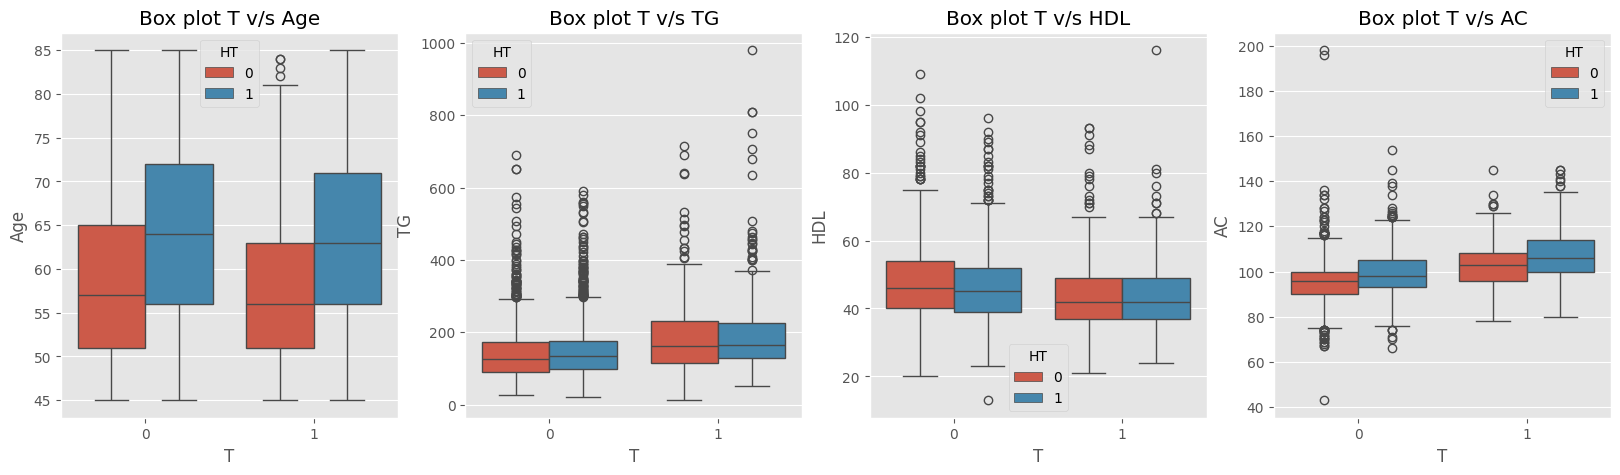

In [24]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

sns.boxplot(data, x = 'T', y = 'Age', hue = 'HT', ax = axs[0])
axs[0].set_title('Box plot T v/s Age')

sns.boxplot(data, x = 'T', y = 'TG', hue = 'HT', ax = axs[1])
axs[1].set_title('Box plot T v/s TG')

sns.boxplot(data, x = 'T', y = 'HDL', hue = 'HT', ax = axs[2])
axs[2].set_title('Box plot T v/s HDL')

sns.boxplot(data, x = 'T', y = 'AC', hue = 'HT', ax = axs[3])
axs[3].set_title('Box plot T v/s AC')

plt.show()

> **Probability distribution Curves**

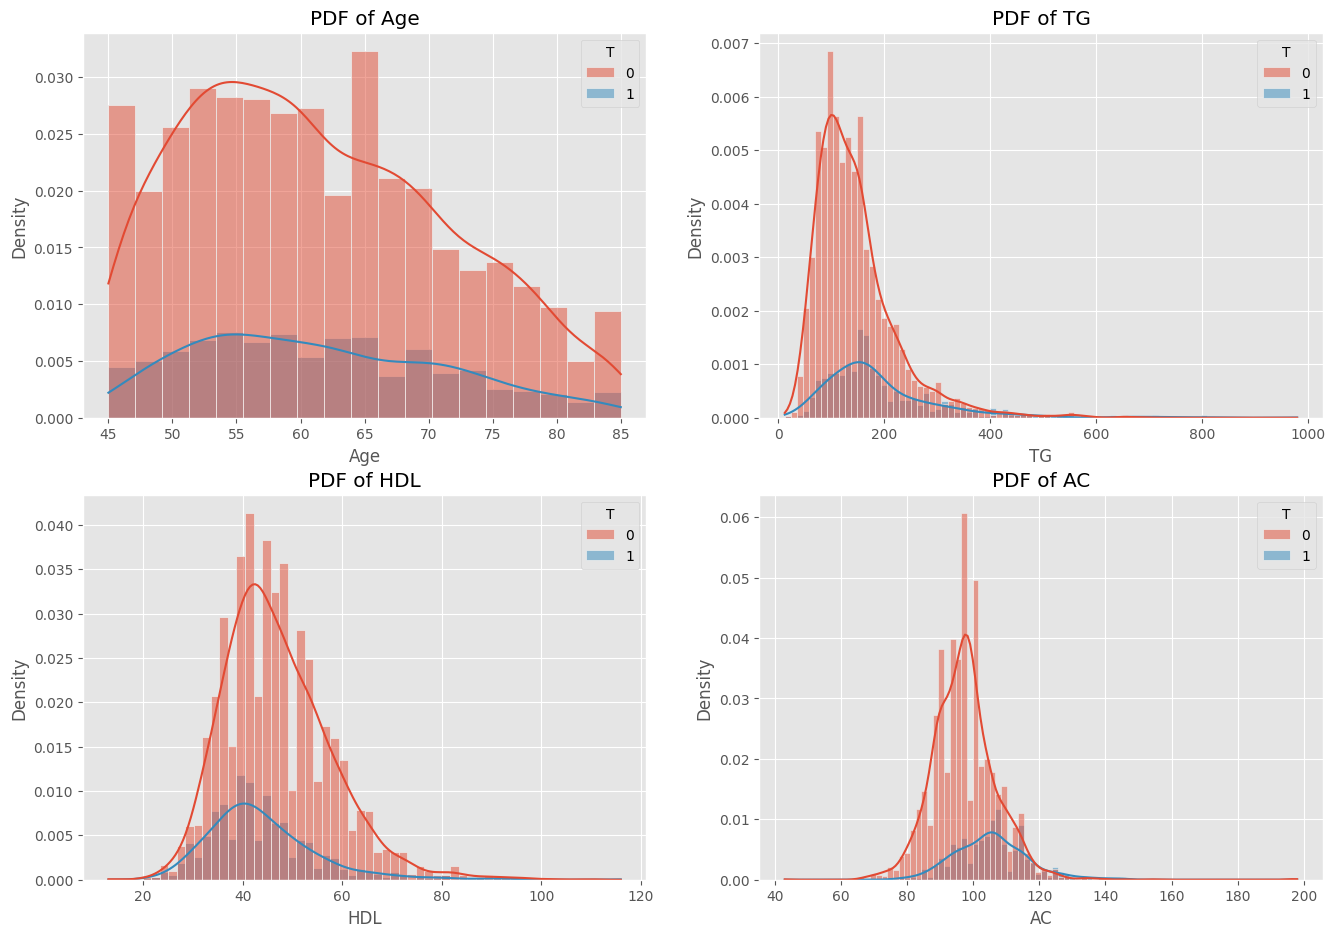

In [25]:
fig, axs = plt.subplots(2, 2, figsize=(16, 11))

sns.histplot(data = data, x = 'Age', kde = True, hue = 'T',stat = "density", ax=axs[0][0])
axs[0][0].set_title('PDF of Age')

sns.histplot(data = data, x = 'TG', kde = True, hue = 'T', stat = "density", ax=axs[0][1])
axs[0][1].set_title('PDF of TG')

sns.histplot(data = data, x = 'HDL', kde = True, hue = 'T', stat = "density", ax=axs[1][0])
axs[1][0].set_title('PDF of HDL')

sns.histplot(data = data, x = 'AC', kde = True, hue = 'T', stat = "density", ax=axs[1][1])
axs[1][1].set_title('PDF of AC')
plt.show()

#### 5.1.3. Categorical v/s Categorical

> **Heat maps**

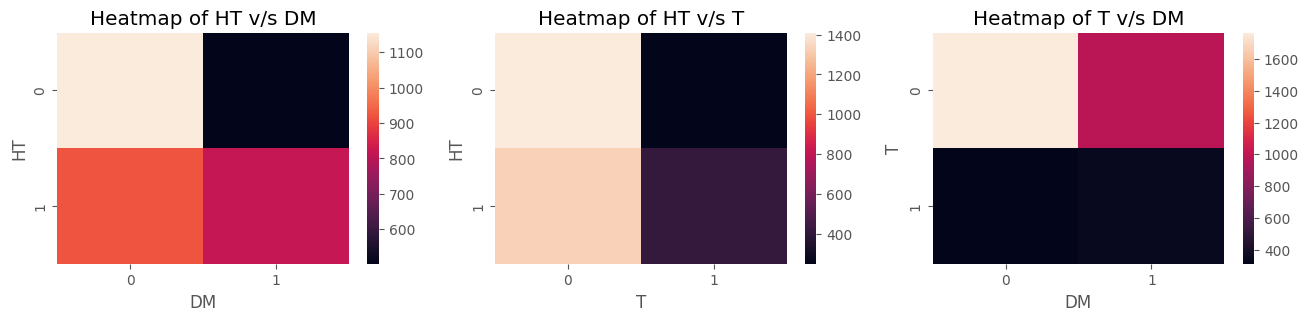

In [26]:
fig, axs = plt.subplots(1, 3, figsize=(16,3))

sns.heatmap(pd.crosstab(data['HT'],data['DM']), ax = axs[0])
axs[0].set_title('Heatmap of HT v/s DM')

sns.heatmap(pd.crosstab(data['HT'],data['T']), ax = axs[1])
axs[1].set_title('Heatmap of HT v/s T')

sns.heatmap(pd.crosstab(data['T'],data['DM']), ax = axs[2])
axs[2].set_title('Heatmap of T v/s DM')

plt.show()


### 5.2. Time graph analysis

<Axes: xlabel='Age', ylabel='T'>

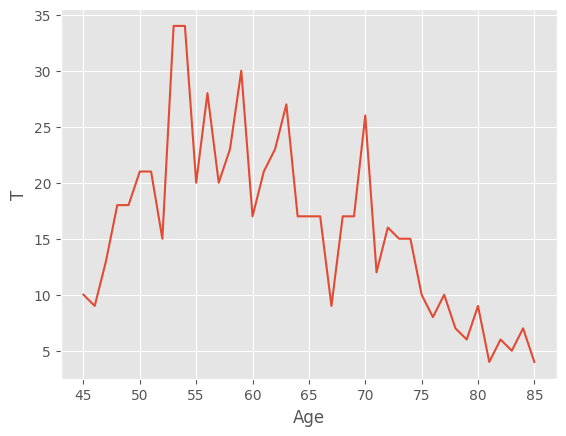

In [27]:
age_data = data.groupby('Age').sum()[['T']].reset_index()
sns.lineplot(age_data, x = 'Age', y = 'T')

<Axes: xlabel='Age', ylabel='DM'>

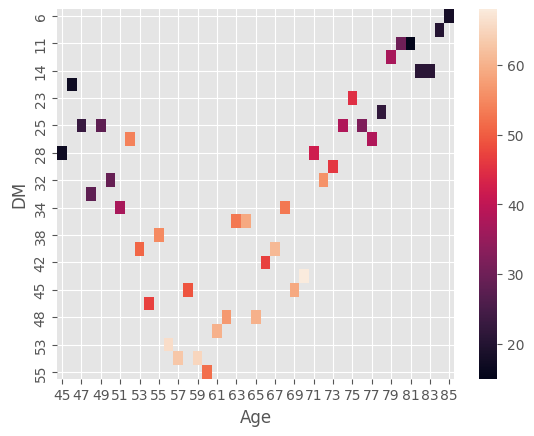

In [28]:
age2_data = data.groupby('Age').sum()[['DM','HT']].reset_index()
sns.heatmap(age2_data.pivot_table(values = 'HT', index = 'DM', columns = 'Age'))

## Pandas-profiling

In [29]:
# !pip install ydata-profiling

In [30]:
# from ydata_profiling import ProfileReport
# profile = ProfileReport(data, title="Profiling Report_1")
# profile.to_file(output_file = 'EDA_Report_before.html')

## 6. Data Preprocessing

1. Remove duplicate rows
2. Splitting IV and DV
3. SMOTE technique for handling imbalanced dataset
4. Remove duplicate rows
   i. Check for inconsistency acc. to business conducts
   ii. Fix decimal points of float variables.
5. Checking data distribution
6. Handling outliers
7. Feature scaling

### 1. Remove Duplicate Rows

In [31]:
data = data.drop_duplicates(keep = 'first',ignore_index = True)

### 2. Splitting Independent and Dependent variable

In [32]:
feature_list = []
target_list = []
for feature in data.columns:
  if feature != 'T':
    feature_list.append(feature)
  elif feature == 'T':
    target_list.append(feature)

X = data[feature_list]
Y = data[target_list]

In [33]:
X

,Age,DM,TG,HT,HDL,AC
0,60,0,145,1,35.0,114.0
1,75,0,93,0,48.0,84.0
2,50,0,151,0,57.0,99.0
3,62,0,178,1,28.0,109.0
4,55,0,138,1,62.0,98.0
...,...,...,...,...,...,...
3385,67,1,87,1,43.0,108.0
3386,77,0,65,1,37.0,104.0
3387,74,1,707,1,30.0,117.0
3388,61,1,164,1,54.0,99.0


### 3. SMOTE

In [34]:
from imblearn.combine import SMOTETomek as stm
os = stm(random_state = 19)
X_new,Y_new = os.fit_resample(X,Y)

In [35]:
X_new

,Age,DM,TG,HT,HDL,AC
0,60,0,145,1,35.000000,114.000000
1,75,0,93,0,48.000000,84.000000
2,50,0,151,0,57.000000,99.000000
3,62,0,178,1,28.000000,109.000000
4,55,0,138,1,62.000000,98.000000
...,...,...,...,...,...,...
5289,71,1,716,1,30.390082,116.707439
5290,69,1,169,1,41.032533,120.644978
5291,49,0,237,0,59.335132,98.162169
5292,62,0,117,0,71.486455,109.555949


### 4. Again, remove duplicate rows

In [36]:
data = pd.concat([X_new, Y_new], axis=1)
data

,Age,DM,TG,HT,HDL,AC,T
0,60,0,145,1,35.000000,114.000000,0
1,75,0,93,0,48.000000,84.000000,0
2,50,0,151,0,57.000000,99.000000,0
3,62,0,178,1,28.000000,109.000000,0
4,55,0,138,1,62.000000,98.000000,0
...,...,...,...,...,...,...,...
5289,71,1,716,1,30.390082,116.707439,1
5290,69,1,169,1,41.032533,120.644978,1
5291,49,0,237,0,59.335132,98.162169,1
5292,62,0,117,0,71.486455,109.555949,1


In [37]:
data.duplicated().sum()

2

In [38]:
data = data.drop_duplicates(ignore_index = True).round(1)

### 5. Checking Data distribution

In [39]:
data.sample(5)

,Age,DM,TG,HT,HDL,AC,T
1469,59,0,177,1,59.0,93.0,0
2571,54,0,92,1,28.0,106.0,0
4638,56,0,369,1,44.0,99.2,1
3980,80,0,121,0,38.8,117.8,1
891,49,1,181,0,40.0,90.0,0


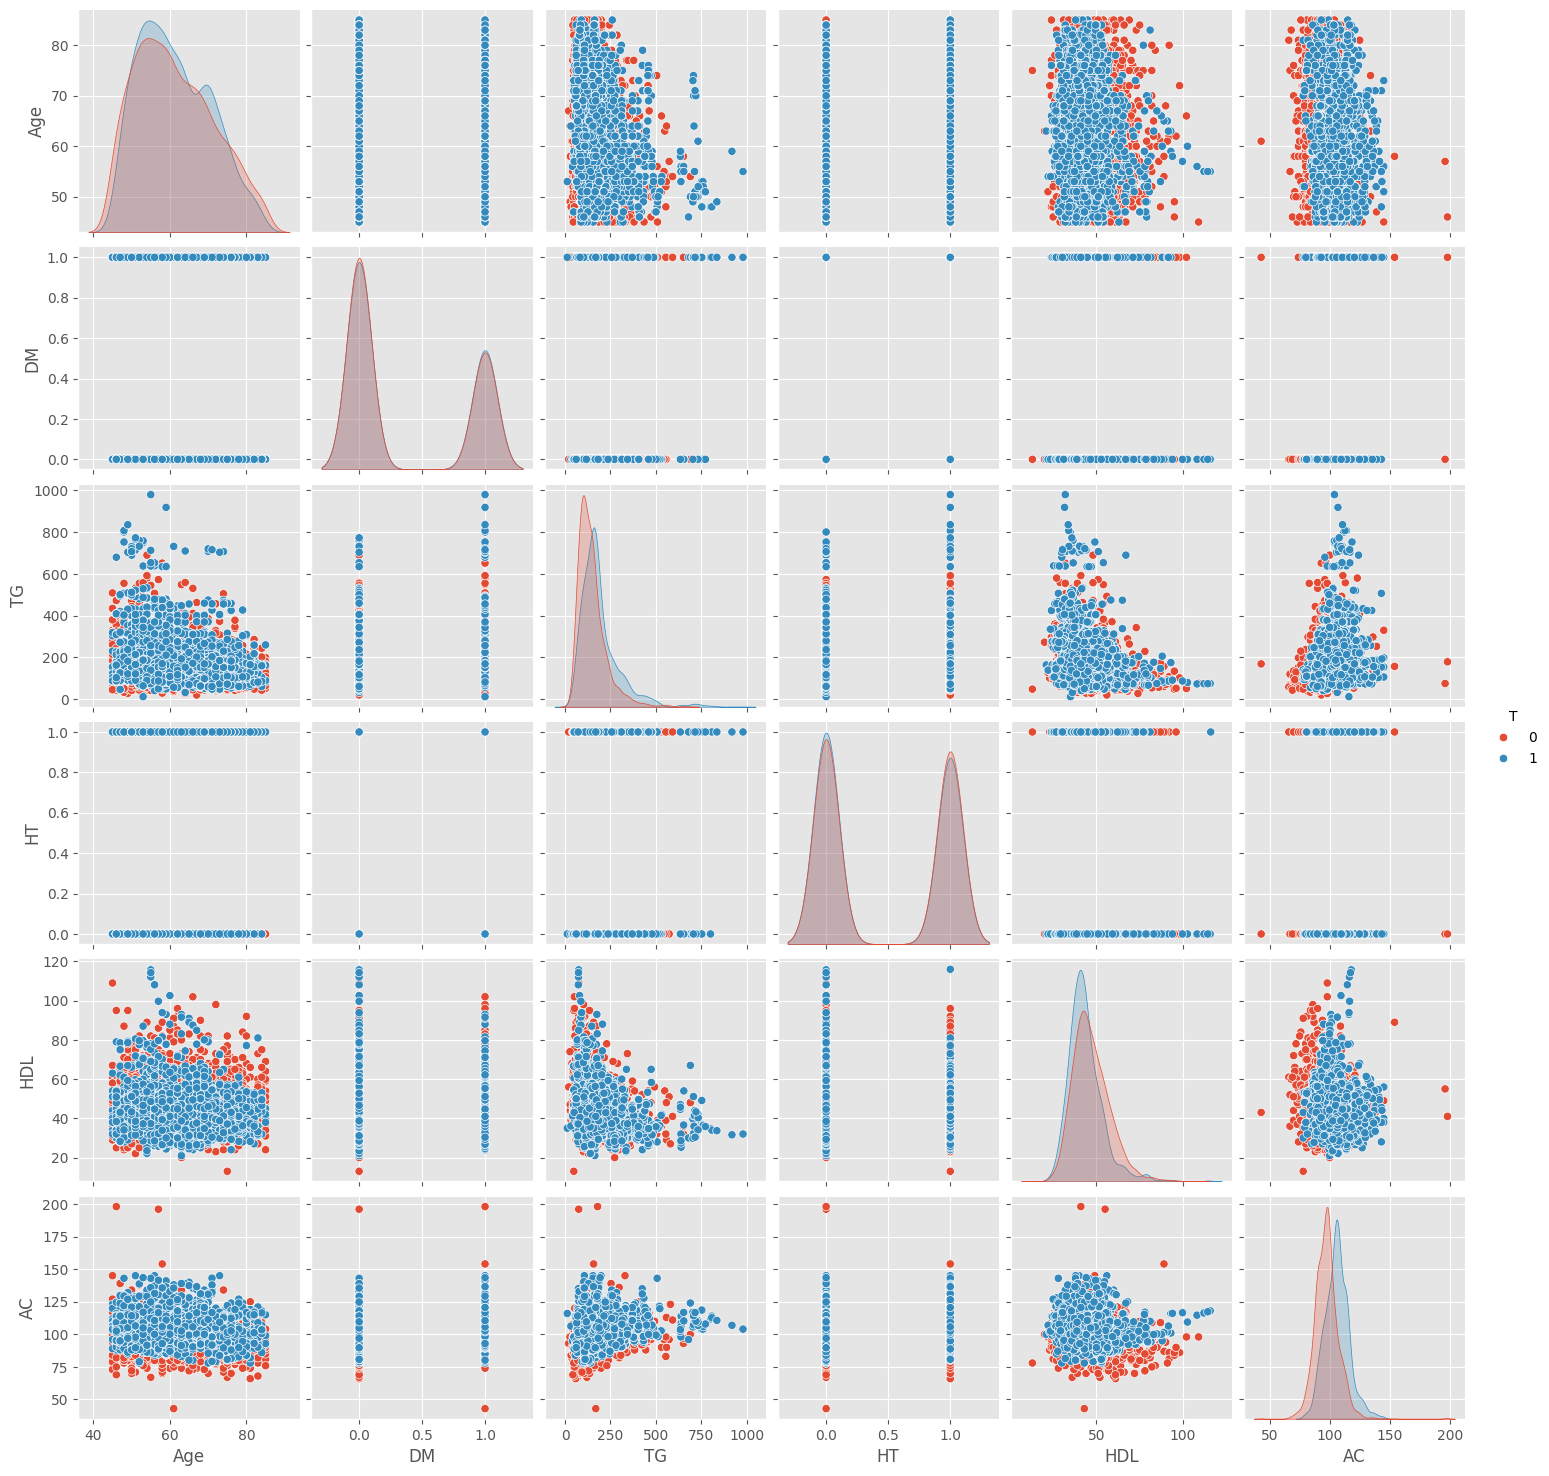

In [40]:
sns.pairplot(data, hue = 'T')

In [41]:
stats = {}
for feature in numerical:
  stats[feature] = {'Mean' : round(data[feature].mean(),2),
                    'Median': round(data[feature].median(),2),
                    'Mode': round(data[feature].mode()[0],2),
                    'Standard deviation': round(data[feature].std(),2),
                    'Coefficient of skewness': round(data[feature].skew(),2)}
for key, value in stats.items():
    print(f"{key}: {value}")

Age: {'Mean': 61.26, 'Median': 60.0, 'Mode': 53, 'Standard deviation': 9.72, 'Coefficient of skewness': 0.39}
TG: {'Mean': 168.58, 'Median': 150.0, 'Mode': 154, 'Standard deviation': 99.87, 'Coefficient of skewness': 2.33}
HDL: {'Mean': 45.29, 'Median': 43.45, 'Mode': 41.0, 'Standard deviation': 10.75, 'Coefficient of skewness': 1.28}
AC: {'Mean': 101.56, 'Median': 101.0, 'Mode': 98.0, 'Standard deviation': 10.88, 'Coefficient of skewness': 0.58}


### 6. Handling outliers

#### 6.6.1. Outlier Visualization

In [42]:
outlier_list = []
u = []
l = []
for feature in numerical:
  per25 = data[feature].quantile(0.25)
  per75 = data[feature].quantile(0.75)
  iqr = per75-per25
  upper = per75 + 1.5 * iqr
  lower = per25 - 1.5 * iqr
  noutlier = data[(data[feature] < lower) | (data[feature] > upper)].shape[0]
  nrows = data.shape[0]
  print(f'Total outlier percentage in {feature}: {noutlier/nrows*100:.2f}')

  outlier_list.append(noutlier)
  u.append(upper)
  l.append(lower)

non_outlier_list = [nrows-x for x in outlier_list]

Total outlier percentage in Age: 0.00
Total outlier percentage in TG: 6.10
Total outlier percentage in HDL: 2.70
Total outlier percentage in AC: 1.66


<Figure size 1000x600 with 0 Axes>

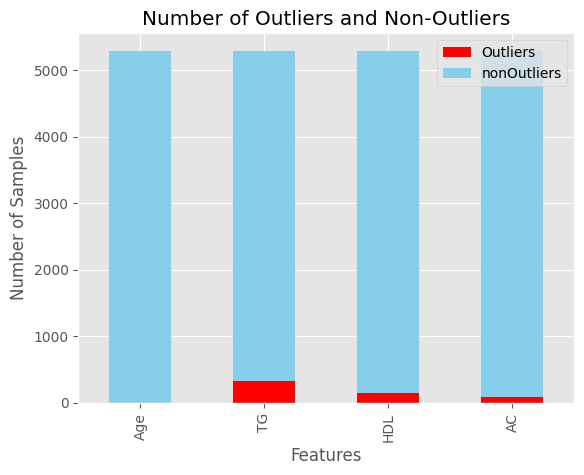

In [43]:
plot_data = pd.DataFrame({'Outliers': outlier_list, 'nonOutliers': non_outlier_list}, index = numerical)
plt.figure(figsize=(10, 6))
plot_data.plot(kind='bar', stacked=True, color=['red', 'skyblue'])
plt.xlabel('Features')
plt.ylabel('Number of Samples')
plt.title('Number of Outliers and Non-Outliers')
plt.show()

> **Trimming**

In [44]:
df = data

for i in range(len(numerical)):
  df = df[(df[numerical[i]] >= l[i]) & (df[numerical[i]] <= u[i])]

#### 6.6.2. Before and After Comparison

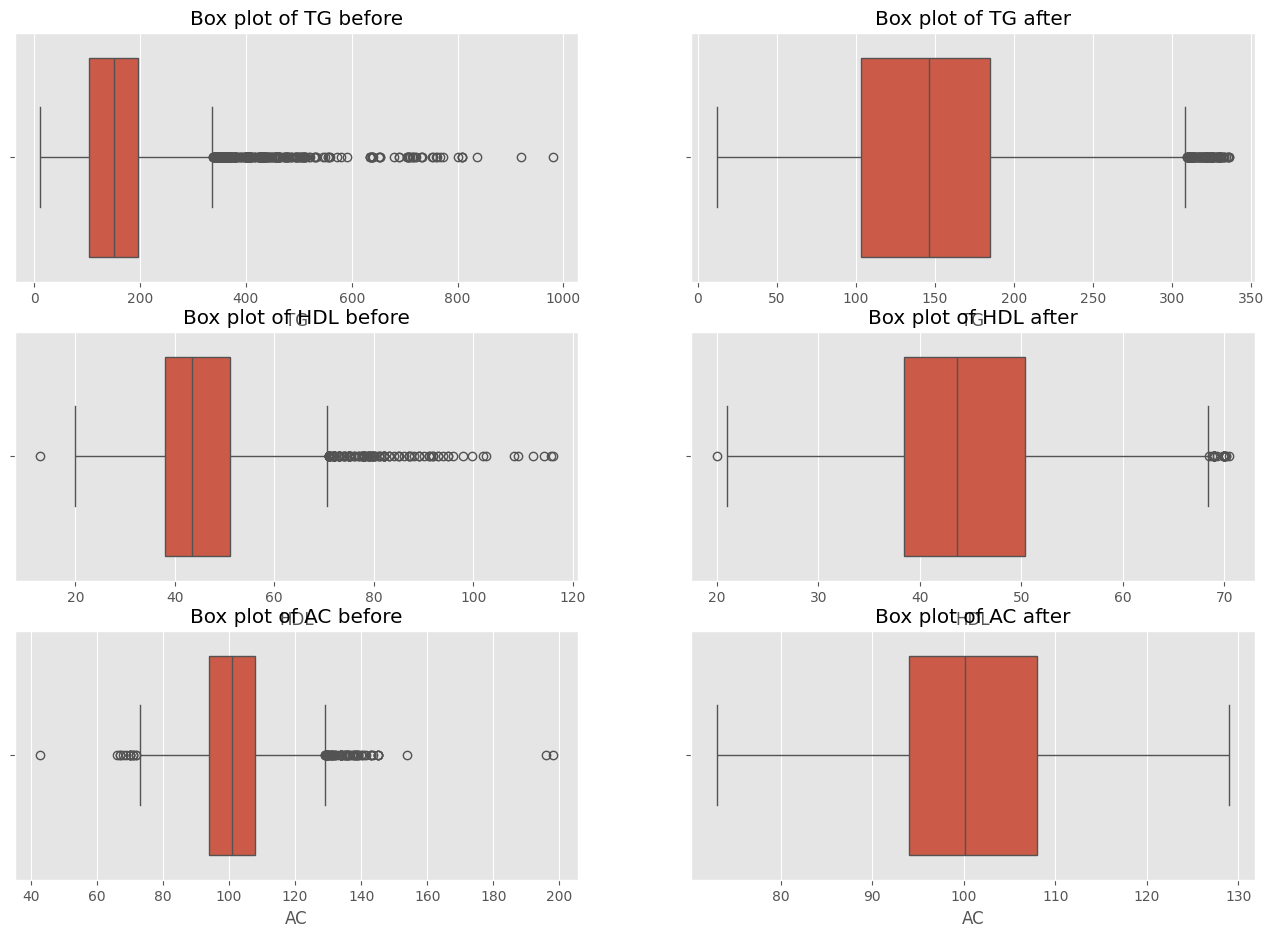

In [45]:
fig, axs = plt.subplots(3, 2, figsize=(16, 11))

sns.boxplot(data['TG'],orient = 'h', ax=axs[0][0])
axs[0][0].set_title('Box plot of TG before')

sns.boxplot(df['TG'],orient = 'h', ax=axs[0][1])
axs[0][1].set_title('Box plot of TG after')

sns.boxplot(data['HDL'],orient = 'h', ax=axs[1][0])
axs[1][0].set_title('Box plot of HDL before')

sns.boxplot(df['HDL'],orient = 'h', ax=axs[1][1])
axs[1][1].set_title('Box plot of HDL after')

sns.boxplot(data['AC'],orient = 'h', ax=axs[2][0])
axs[2][0].set_title('Box plot of AC before')

sns.boxplot(df['AC'],orient = 'h', ax=axs[2][1])
axs[2][1].set_title('Box plot of AC after')
plt.show()

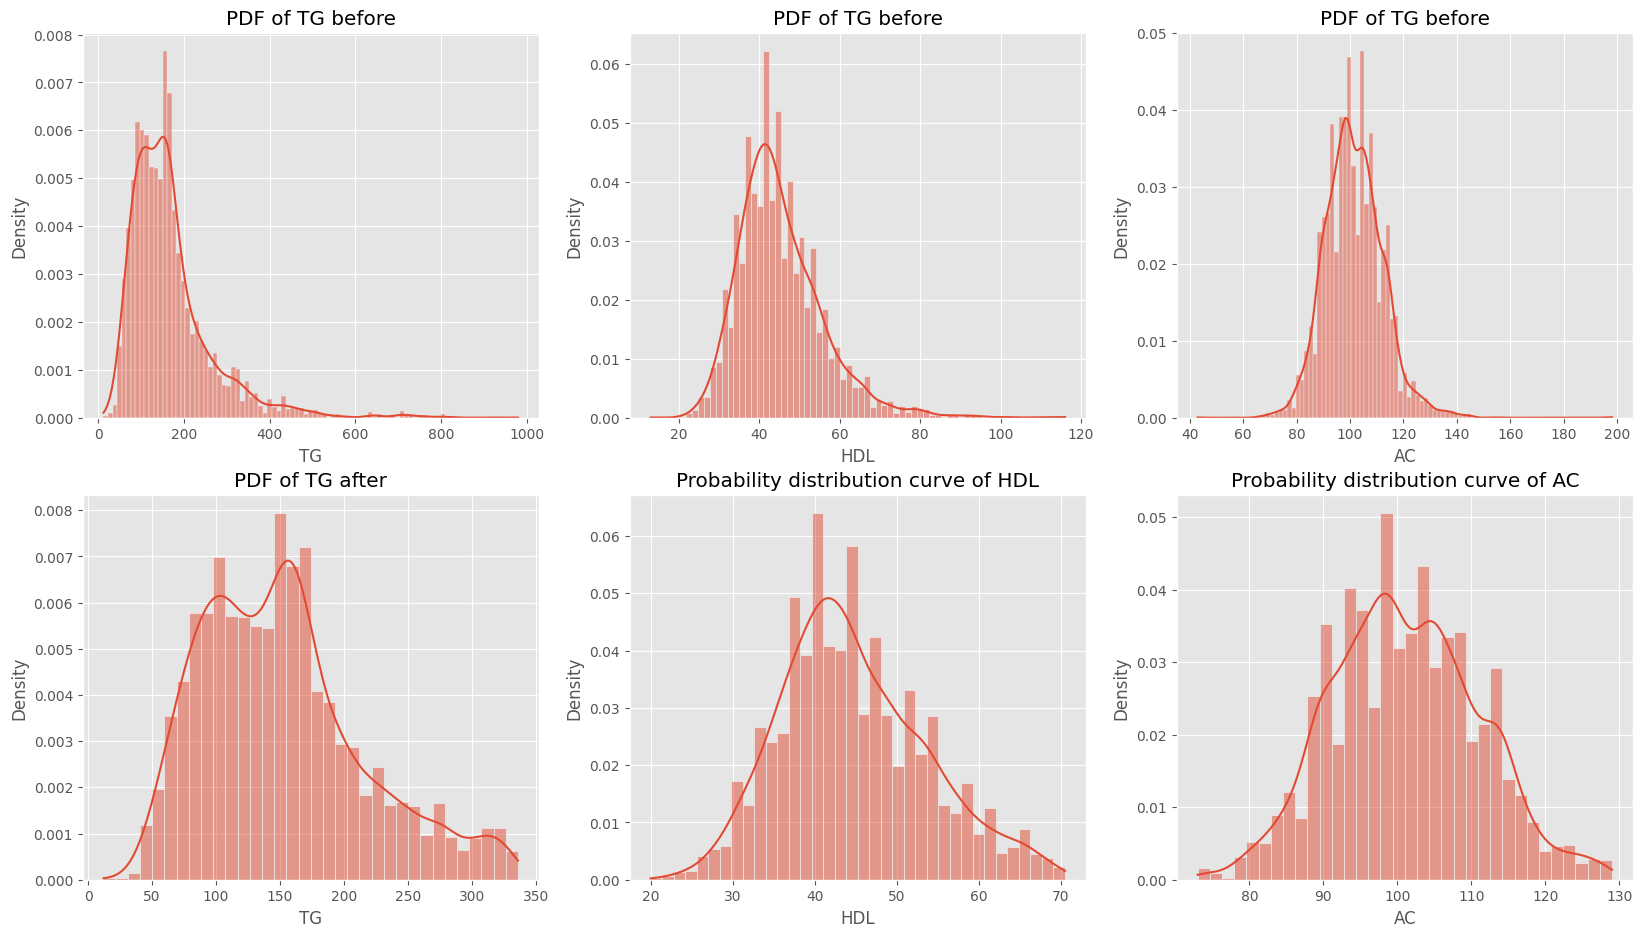

In [46]:
fig, axs = plt.subplots(2, 3, figsize=(20, 11))

sns.histplot(data['TG'],kde=True, stat="density", ax=axs[0][0])
axs[0][0].set_title('PDF of TG before')

sns.histplot(df['TG'],kde=True, stat="density", ax=axs[1][0])
axs[1][0].set_title('PDF of TG after')

sns.histplot(data['HDL'],kde=True, stat="density", ax=axs[0][1])
axs[0][1].set_title('PDF of TG before')

sns.histplot(df['HDL'],kde=True, stat="density", ax=axs[1][1])
axs[1][1].set_title('Probability distribution curve of HDL')

sns.histplot(data['AC'],kde=True, stat="density", ax=axs[0][2])
axs[0][2].set_title('PDF of TG before')

sns.histplot(df['AC'],kde=True, stat="density", ax=axs[1][2])
axs[1][2].set_title('Probability distribution curve of AC')
plt.show()

## 7. Models

In [292]:
model_list = ['SVM','RF','XGB','KNN','NB','ANN']
accuracy_list = []
precision_list = []
specificity_list = []
sensitivity_list = []
f1score_list = []
roc_auc_list = []

### 7.1. SVC

> **Feature selection & Train - Test split**

In [293]:
# X -> IV & Y -> DV
X = df.drop(['T', 'DM'], axis=1) # feature selection
y = df['T']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1902)
X_train.shape, X_test.shape

((3796, 5), (949, 5))

> **Model creation & Training**

In [294]:
svc = SVC()
svc.fit(X_train,y_train)

SVC()

> **Inference**

In [295]:
y_pred = svc.predict(X_test)

> **Evaluation**

In [296]:
print('SVM Model accuracy score on Train data: {0:0.4f}'. format(accuracy_score(y_train, svc.predict(X_train)) * 100))
print('SVM Model accuracy score on Test data: {0:0.4f}'. format(accuracy_score(y_test, y_pred) * 100))

SVM Model accuracy score on Train data: 68.9146
SVM Model accuracy score on Test data: 69.4415


> **Hyperparameter Tuning**

In [297]:
svc = SVC()
params = {'C':[1, 10, 100, 1000], 'kernel':['rbf'], 'gamma':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}
grid_search = GridSearchCV(svc,
                           param_grid = params,
                           scoring = 'accuracy',
                           cv = 5,
                           verbose=0)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [1, 10, 100, 1000],
                         'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
                         'kernel': ['rbf']},
             scoring='accuracy')

In [298]:
# Best SVC Model
best_svc = grid_search.best_estimator_
y_pred = best_svc.predict(X_test)

print('GridSearch CV best score : {:.4f}\n'.format(grid_search.best_score_ * 100))
print('Parameters that give the best results :','\n', (grid_search.best_params_))
print('\nEstimator that was chosen by the search :','\n', (grid_search.best_estimator_))

print('\nGridSearch CV score on test set: {0:0.4f}'.format(grid_search.score(X_test, y_test) * 100))

GridSearch CV best score : 88.6461

Parameters that give the best results : 
 {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

Estimator that was chosen by the search : 
 SVC(C=10, gamma=0.1)

GridSearch CV score on test set: 88.6196


> **Confusion matrix**

Confusion matrix

 [[473  29]
 [ 79 368]]

True Positives(TP) [Actual Positive:1 and Predict Positive:1] =  473

True Negatives(TN) [Actual Negative:0 and Predict Negative:0] =  368

False Positives(FP) [Actual Negative:0 but Predict Positive:1] =  29

False Negatives(FN) [Actual Positive:1 but Predict Negative:0] =  79

The confusion matrix shows 473 + 368 = 841 correct predictions and 29 + 79 = 108 incorrect predictions.


<Axes: >

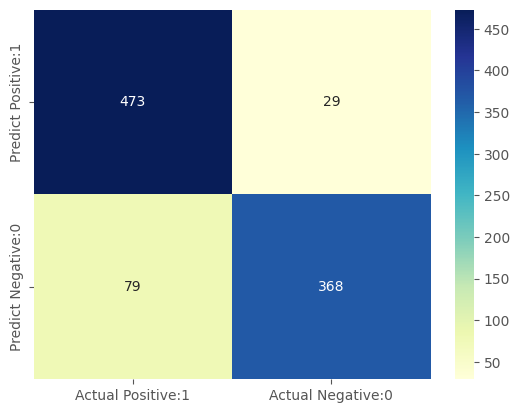

In [299]:
cm = confusion_matrix(y_test, y_pred)

print('Confusion matrix\n\n', cm)

print('\nTrue Positives(TP) [Actual Positive:1 and Predict Positive:1] = ', cm[0,0])
print('\nTrue Negatives(TN) [Actual Negative:0 and Predict Negative:0] = ', cm[1,1])
print('\nFalse Positives(FP) [Actual Negative:0 but Predict Positive:1] = ', cm[0,1])
print('\nFalse Negatives(FN) [Actual Positive:1 but Predict Negative:0] = ', cm[1,0])

print(f'\nThe confusion matrix shows {cm[0,0]} + {cm[1,1]} = {cm[0,0] + cm[1,1]} correct predictions and {cm[0,1]} + {cm[1,0]} = {cm[0,1] + cm[1,0]} incorrect predictions.')

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'],
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

> **Best Model Evaluation Metrics**

In [300]:
TP = cm[0,0]
TN = cm[1,1]
FP = cm[0,1]
FN = cm[1,0]

accuracy = accuracy_score(y_test, y_pred) * 100
precision = precision_score(y_test, y_pred) * 100
specificity = TN / (TN + FP) * 100
recall = recall_score(y_test, y_pred) * 100
f1score = f1_score(y_test,y_pred) * 100

print("Best SVM Accuracy : {0:0.2f}".format(accuracy))
print("Best SVM Precision : {0:0.2f}".format(precision))
print("Best SVM Specificity : {0:0.2f}".format(specificity))
print("Best SVM Recall or Sensitivity : {0:0.2f}".format(recall))
print("Best SVM F1_score : {0:0.2f}".format(f1score))

accuracy_list.append(accuracy)
precision_list.append(precision)
specificity_list.append(specificity)
sensitivity_list.append(recall)
f1score_list.append(f1score)

Best SVM Accuracy : 88.62
Best SVM Precision : 92.70
Best SVM Specificity : 92.70
Best SVM Recall or Sensitivity : 82.33
Best SVM F1_score : 87.20


> **ROC-AUC Analysis**

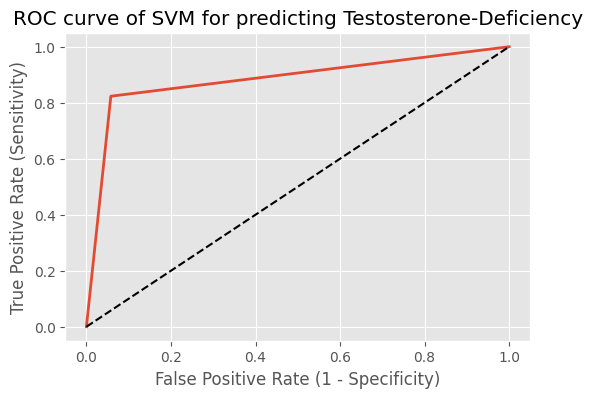

Best SVM ROC AUC : 0.8827


In [301]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1], [0,1], 'k--' )
plt.rcParams['font.size'] = 10
plt.title('ROC curve of SVM for predicting Testosterone-Deficiency')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

plt.show()

ROC_AUC = roc_auc_score(y_test, y_pred)
print('Best SVM ROC AUC : {:.4f}'.format(ROC_AUC))
# ROC AUC is a single number summary of classifier performance. The higher the value, the better the classifier.
# A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5.
roc_auc_list.append(ROC_AUC)

### 7.2. Random Forest

> **Feature selection & Train - Test split**

In [302]:
# X -> IV & Y -> DV
X = df.drop(['T', 'DM'], axis=1) # feature selection
y = df['T']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1902)

# Normalization
cols = X_train.columns
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = pd.DataFrame(X_train, columns=[cols])
X_test = pd.DataFrame(X_test, columns=[cols])

> **Model creation & Training**

In [303]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

> **Inference**

In [304]:
y_pred = rf.predict(X_test)

> **Evaluation**

In [305]:
print("RF Model accuracy score on Train data: {0:0.4f}".format(accuracy_score(y_train, rf.predict(X_train)) * 100))
print("RF Model accuracy score on Test data: {0:0.4f}".format(accuracy_score(y_test, y_pred) * 100))

RF Model accuracy score on Train data: 100.0000
RF Model accuracy score on Test data: 85.6691


> **Top 3 Decision Tree**

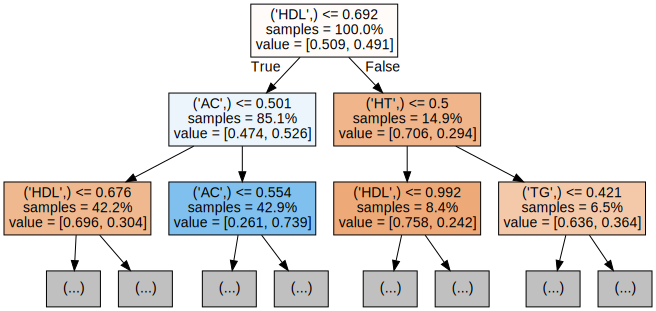

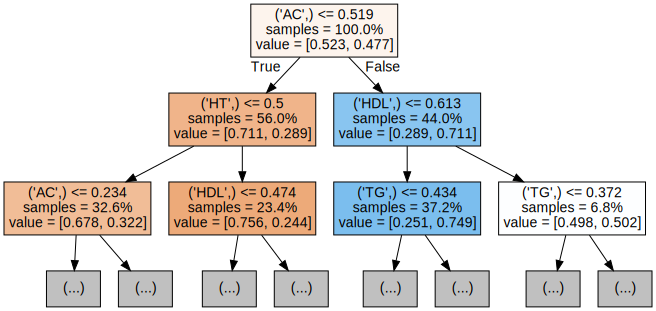

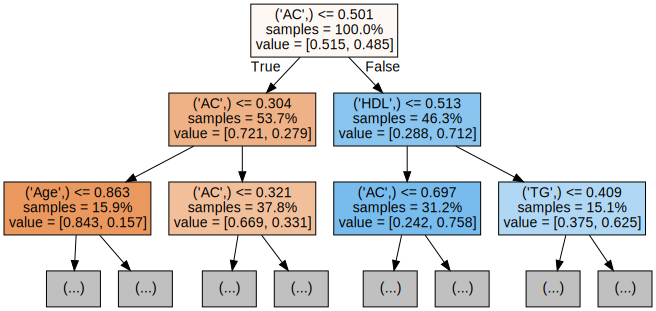

In [306]:
# first three decision trees from the forest
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,
                               filled=True,
                               max_depth=2,
                               impurity=False,
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

> **Important Feature Analysis**

<Axes: xlabel='Feature'>

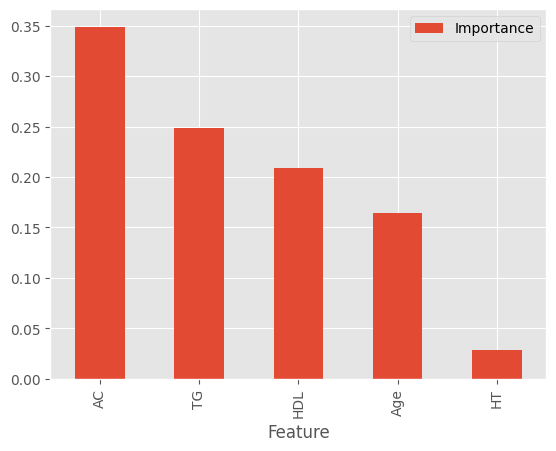

In [307]:
importances = pd.DataFrame({
    'Feature': cols,
    'Importance': rf.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)
importances = importances.set_index('Feature')
importances.plot.bar()

> **Hyperparameter Tuning**

In [308]:
rf = RandomForestClassifier()
params = [{
    'n_estimators': randint(500,1000),
    'max_depth': randint(5, 100)
}]
rand_search = RandomizedSearchCV(rf, param_distributions=params, scoring='accuracy', n_iter=5,cv=5)

rand_search.fit(X_train.drop('HT',axis = 1), y_train)

<ipython-input-308-277ba5bdc8d8>:8: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  rand_search.fit(X_train.drop('HT',axis = 1), y_train)


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions=[{'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7cd3cbd175e0>,
                                         'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7cd3cbea4ca0>}],
                   scoring='accuracy')

In [309]:
# Best RF Model
best_rf = rand_search.best_estimator_
y_pred = best_rf.predict(X_test.drop('HT',axis = 1))

print('RandomizedSearch CV best score : {:.4f}\n'.format(rand_search.best_score_ * 100))
print('Parameters that give the best results :','\n', (rand_search.best_params_))
print('\nEstimator that was chosen by the search :','\n', (rand_search.best_estimator_))

print('\nRandomizedSearch CV score on test set: {0:0.4f}'.format(rand_search.score(X_test.drop('HT',axis = 1), y_test) * 100))

<ipython-input-309-a9ab9d819c94>:3: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  y_pred = best_rf.predict(X_test.drop('HT',axis = 1))
<ipython-input-309-a9ab9d819c94>:9: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  print('\nRandomizedSearch CV score on test set: {0:0.4f}'.format(rand_search.score(X_test.drop('HT',axis = 1), y_test) * 100))


RandomizedSearch CV best score : 84.0884

Parameters that give the best results : 
 {'max_depth': 24, 'n_estimators': 653}

Estimator that was chosen by the search : 
 RandomForestClassifier(max_depth=24, n_estimators=653)

RandomizedSearch CV score on test set: 85.8799


> **Confusion matrix**

Confusion matrix

 [[430  72]
 [ 62 385]]

True Positives(TP) [Actual Positive:1 and Predict Positive:1] =  430

True Negatives(TN) [Actual Negative:0 and Predict Negative:0] =  385

False Positives(FP) [Actual Negative:0 but Predict Positive:1] =  72

False Negatives(FN) [Actual Positive:1 but Predict Negative:0] =  62

The confusion matrix shows 430 + 385 = 815 correct predictions and 72 + 62 = 134 incorrect predictions.


<Axes: >

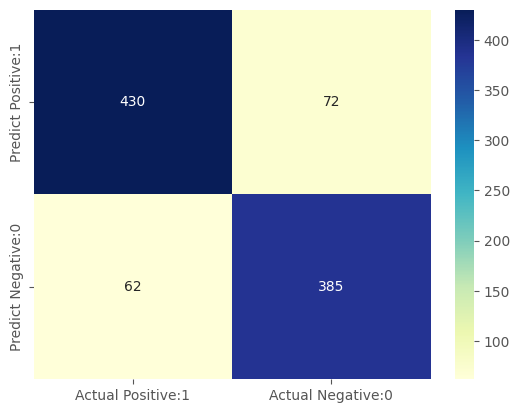

In [310]:
cm = confusion_matrix(y_test, y_pred)

print('Confusion matrix\n\n', cm)

print('\nTrue Positives(TP) [Actual Positive:1 and Predict Positive:1] = ', cm[0,0])
print('\nTrue Negatives(TN) [Actual Negative:0 and Predict Negative:0] = ', cm[1,1])
print('\nFalse Positives(FP) [Actual Negative:0 but Predict Positive:1] = ', cm[0,1])
print('\nFalse Negatives(FN) [Actual Positive:1 but Predict Negative:0] = ', cm[1,0])

print(f'\nThe confusion matrix shows {cm[0,0]} + {cm[1,1]} = {cm[0,0] + cm[1,1]} correct predictions and {cm[0,1]} + {cm[1,0]} = {cm[0,1] + cm[1,0]} incorrect predictions.')

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'],
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

> **Best Model Evaluation Metrics**

In [311]:
TP = cm[0,0]
TN = cm[1,1]
FP = cm[0,1]
FN = cm[1,0]

accuracy = accuracy_score(y_test, y_pred) * 100
precision = precision_score(y_test, y_pred) * 100
specificity = TN / (TN + FP) * 100
recall = recall_score(y_test, y_pred) * 100
f1score = f1_score(y_test,y_pred) * 100

print("Best RF Accuracy : {0:0.2f}".format(accuracy))
print("Best RF Precision : {0:0.2f}".format(precision))
print("Best RF Specificity : {0:0.2f}".format(specificity))
print("Best RF Recall or Sensitivity : {0:0.2f}".format(recall))
print("Best RF F1_score : {0:0.2f}".format(f1score))

accuracy_list.append(accuracy)
precision_list.append(precision)
specificity_list.append(specificity)
sensitivity_list.append(recall)
f1score_list.append(f1score)

Best RF Accuracy : 85.88
Best RF Precision : 84.25
Best RF Specificity : 84.25
Best RF Recall or Sensitivity : 86.13
Best RF F1_score : 85.18


> **ROC-AUC Analysis**

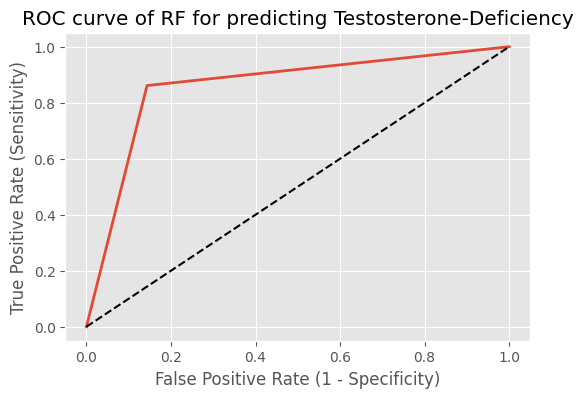

ROC AUC : 0.8589


In [312]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1], [0,1], 'k--' )
plt.rcParams['font.size'] = 10
plt.title('ROC curve of RF for predicting Testosterone-Deficiency')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

plt.show()

ROC_AUC = roc_auc_score(y_test, y_pred)
print('ROC AUC : {:.4f}'.format(ROC_AUC))
roc_auc_list.append(ROC_AUC)

### 7.3. XGBoost

> **Feature selection & Train - Test split**

In [313]:
# X -> IV & Y -> DV
X = df.drop(['T', 'Age'], axis=1) # feature selection
y = df['T']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1902)

> **Model creation & Training**

In [314]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

> **Inference**

In [315]:
y_pred = xgb.predict(X_test)

> **Evaluation**

In [316]:
print("XGBoost Model accuracy score on Train data: {0:0.4f}".format(accuracy_score(y_train, xgb.predict(X_train))))
print("XGBoost Model accuracy score on Test data: {0:0.4f}".format(accuracy_score(y_test, y_pred)))

XGBoost Model accuracy score on Train data: 0.9660
XGBoost Model accuracy score on Test data: 0.8599


> **Important Feature Analysis**

<Axes: xlabel='Feature'>

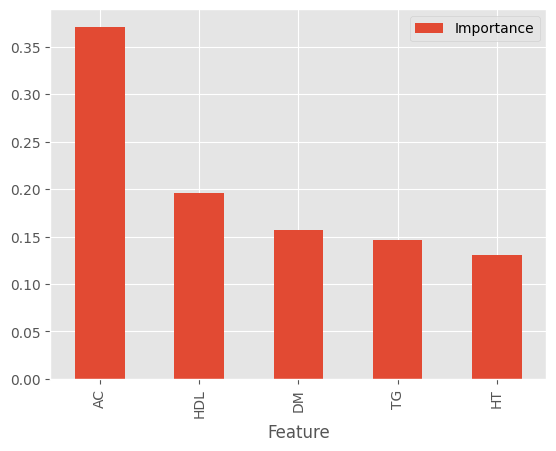

In [317]:
importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)
importances = importances.set_index('Feature')
importances.plot.bar()

> **Hyperparameter Tuning**

In [318]:
xgb = XGBClassifier()
params = {

        'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'n_estimators': randint(1, 1000),
        'reg_alpha':[1e-5, 1e-2, 0.1,1e-3, 1e-4],
        'reg_lambda': [1e-5, 1e-2, 0.1,1e-3, 1e-4],
        }
rand_search = RandomizedSearchCV(xgb, param_distributions=params, scoring='accuracy', n_iter=20, cv=5)

rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   n_iter=20,
                   param_distributions={'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6,
                                                  0.7, 0.8, 0.9, 1.0],
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7cd3cbc709d0>,
                                        'reg_alpha': [1e-05, 0.01, 0.1, 0.001,
                                                      0.0001],
                                        'reg_lambda': [1e-05, 0.01, 0.1, 0.001,
                                                       0.0001]},
                   scoring='accuracy')

In [319]:
# Best XGBoost Model
best_xgb = rand_search.best_estimator_
y_pred = best_xgb.predict(X_test)

print('RandomizedSearch CV best score : {:.4f}\n'.format(rand_search.best_score_ * 100))
print('Parameters that give the best results :','\n', (rand_search.best_params_))
print('\nEstimator that was chosen by the search :','\n', (rand_search.best_estimator_))

print('\nRandomizedSearch CV score on test set: {0:0.4f}'.format(rand_search.score(X_test, y_test) * 100))

RandomizedSearch CV best score : 83.8246

Parameters that give the best results : 
 {'gamma': 0.1, 'n_estimators': 807, 'reg_alpha': 0.01, 'reg_lambda': 0.001}

Estimator that was chosen by the search : 
 XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=807, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

RandomizedSearch CV score on test set:

> **Confusion matrix**

Confusion matrix

 [[448  54]
 [ 77 370]]

True Positives(TP) [Actual Positive:1 and Predict Positive:1] =  448

True Negatives(TN) [Actual Negative:0 and Predict Negative:0] =  370

False Positives(FP) [Actual Negative:0 but Predict Positive:1] =  54

False Negatives(FN) [Actual Positive:1 but Predict Negative:0] =  77

The confusion matrix shows 448 + 370 = 818 correct predictions and 54 + 77 = 131 incorrect predictions.


<Axes: >

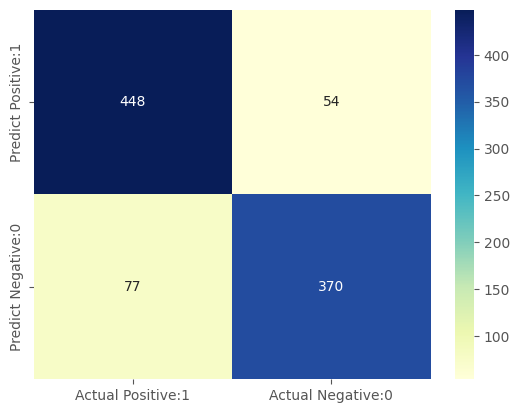

In [320]:
cm = confusion_matrix(y_test, y_pred)

print('Confusion matrix\n\n', cm)

print('\nTrue Positives(TP) [Actual Positive:1 and Predict Positive:1] = ', cm[0,0])
print('\nTrue Negatives(TN) [Actual Negative:0 and Predict Negative:0] = ', cm[1,1])
print('\nFalse Positives(FP) [Actual Negative:0 but Predict Positive:1] = ', cm[0,1])
print('\nFalse Negatives(FN) [Actual Positive:1 but Predict Negative:0] = ', cm[1,0])

print(f'\nThe confusion matrix shows {cm[0,0]} + {cm[1,1]} = {cm[0,0] + cm[1,1]} correct predictions and {cm[0,1]} + {cm[1,0]} = {cm[0,1] + cm[1,0]} incorrect predictions.')

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'],
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

> **Best Model Evaluation Metrics**

In [321]:
TP = cm[0,0]
TN = cm[1,1]
FP = cm[0,1]
FN = cm[1,0]

accuracy = accuracy_score(y_test, y_pred) * 100
precision = precision_score(y_test, y_pred) * 100
specificity = TN / (TN + FP) * 100
recall = recall_score(y_test, y_pred) * 100
f1score = f1_score(y_test,y_pred) * 100

print("Best XGB Accuracy : {0:0.2f}".format(accuracy))
print("Best XGB Precision : {0:0.2f}".format(precision))
print("Best XGB Specificity : {0:0.2f}".format(specificity))
print("Best XGB Recall or Sensitivity : {0:0.2f}".format(recall))
print("Best XGB F1_score : {0:0.2f}".format(f1score))

accuracy_list.append(accuracy)
precision_list.append(precision)
specificity_list.append(specificity)
sensitivity_list.append(recall)
f1score_list.append(f1score)

Best XGB Accuracy : 86.20
Best XGB Precision : 87.26
Best XGB Specificity : 87.26
Best XGB Recall or Sensitivity : 82.77
Best XGB F1_score : 84.96


> **ROC-AUC Analysis**

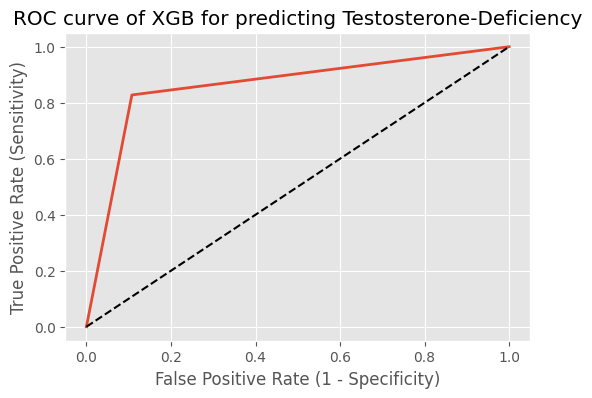

ROC AUC : 0.8601


In [322]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1], [0,1], 'k--' )
plt.rcParams['font.size'] = 10
plt.title('ROC curve of XGB for predicting Testosterone-Deficiency')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

plt.show()

ROC_AUC = roc_auc_score(y_test, y_pred)
print('ROC AUC : {:.4f}'.format(ROC_AUC))
roc_auc_list.append(ROC_AUC)

### 7.4. KNN

> **Feature selection & Train - Test split**

In [324]:
# X -> IV & Y -> DV
X = df.drop(['T'], axis=1) # feature selection
y = df['T']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1902)
X_train.shape, X_test.shape

((3796, 6), (949, 6))

> **Model creation & Training**

In [325]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

> **Inference**

In [326]:
y_pred = knn.predict(X_test)

> **Evaluation**

In [327]:
print("KNN Model accuracy score on Train data: {0:0.4f}".format(accuracy_score(y_train, knn.predict(X_train))))
print("KNN Model accuracy score on Test data: {0:0.4f}".format(accuracy_score(y_test, y_pred)))

KNN Model accuracy score on Train data: 0.8609
KNN Model accuracy score on Test data: 0.7808


> **Hyperparameter Tuning**

In [328]:
knn = KNeighborsClassifier()
params = { 'n_neighbors' : range(5,50),
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']}
grid_search = GridSearchCV(knn, params, scoring = 'accuracy', verbose = 1, cv=5)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 270 candidates, totalling 1350 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['minkowski', 'euclidean', 'manhattan'],
                         'n_neighbors': range(5, 50),
                         'weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=1)

In [329]:
# Best SVC Model
best_knn = grid_search.best_estimator_
y_pred = best_knn.predict(X_test)

print('GridSearch CV best score : {:.4f}\n'.format(grid_search.best_score_ * 100))
print('Parameters that give the best results :','\n', (grid_search.best_params_))
print('\nEstimator that was chosen by the search :','\n', (grid_search.best_estimator_))

print('\nGridSearch CV score on test set: {0:0.4f}'.format(grid_search.score(X_test, y_test) * 100))

GridSearch CV best score : 80.9803

Parameters that give the best results : 
 {'metric': 'manhattan', 'n_neighbors': 6, 'weights': 'distance'}

Estimator that was chosen by the search : 
 KNeighborsClassifier(metric='manhattan', n_neighbors=6, weights='distance')

GridSearch CV score on test set: 80.7165


> **Confusion matrix**

Confusion matrix

 [[348 154]
 [ 29 418]]

True Positives(TP) [Actual Positive:1 and Predict Positive:1] =  348

True Negatives(TN) [Actual Negative:0 and Predict Negative:0] =  418

False Positives(FP) [Actual Negative:0 but Predict Positive:1] =  154

False Negatives(FN) [Actual Positive:1 but Predict Negative:0] =  29

The confusion matrix shows 348 + 418 = 766 correct predictions and 154 + 29 = 183 incorrect predictions.


<Axes: >

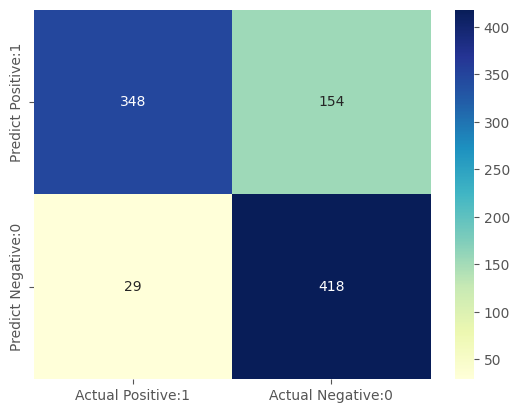

In [330]:
cm = confusion_matrix(y_test, y_pred)

print('Confusion matrix\n\n', cm)

print('\nTrue Positives(TP) [Actual Positive:1 and Predict Positive:1] = ', cm[0,0])
print('\nTrue Negatives(TN) [Actual Negative:0 and Predict Negative:0] = ', cm[1,1])
print('\nFalse Positives(FP) [Actual Negative:0 but Predict Positive:1] = ', cm[0,1])
print('\nFalse Negatives(FN) [Actual Positive:1 but Predict Negative:0] = ', cm[1,0])

print(f'\nThe confusion matrix shows {cm[0,0]} + {cm[1,1]} = {cm[0,0] + cm[1,1]} correct predictions and {cm[0,1]} + {cm[1,0]} = {cm[0,1] + cm[1,0]} incorrect predictions.')

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'],
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

> **Best Model Evaluation Metrics**

In [331]:
TP = cm[0,0]
TN = cm[1,1]
FP = cm[0,1]
FN = cm[1,0]

accuracy = accuracy_score(y_test, y_pred) * 100
precision = precision_score(y_test, y_pred) * 100
specificity = TN / (TN + FP) * 100
recall = recall_score(y_test, y_pred) * 100
f1score = f1_score(y_test,y_pred) * 100

print("Best KNN Accuracy : {0:0.2f}".format(accuracy))
print("Best KNN Precision : {0:0.2f}".format(precision))
print("Best KNN Specificity : {0:0.2f}".format(specificity))
print("Best KNN Recall or Sensitivity : {0:0.2f}".format(recall))
print("Best KNN F1_score : {0:0.2f}".format(f1score))

accuracy_list.append(accuracy)
precision_list.append(precision)
specificity_list.append(specificity)
sensitivity_list.append(recall)
f1score_list.append(f1score)

Best KNN Accuracy : 80.72
Best KNN Precision : 73.08
Best KNN Specificity : 73.08
Best KNN Recall or Sensitivity : 93.51
Best KNN F1_score : 82.04


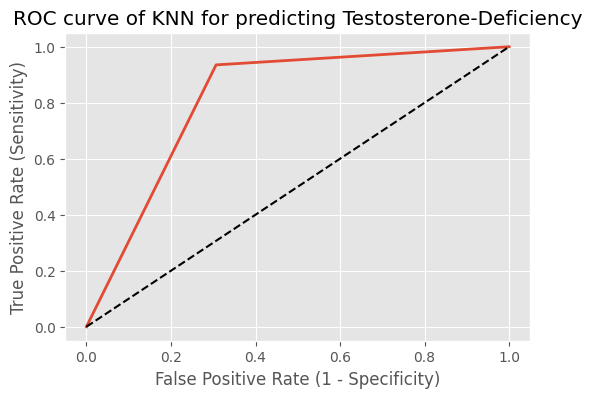

Best SVM ROC AUC : 0.8142


In [332]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1], [0,1], 'k--' )
plt.rcParams['font.size'] = 10
plt.title('ROC curve of KNN for predicting Testosterone-Deficiency')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

plt.show()

ROC_AUC = roc_auc_score(y_test, y_pred)
print('Best KNN ROC AUC : {:.4f}'.format(ROC_AUC))
roc_auc_list.append(ROC_AUC)

### 7.5. ANN

> **Feature selection**

In [345]:
# X -> IV & Y -> DV
X = df.drop(['T', 'DM'], axis=1) # feature selection
y = df['T']
X = t.tensor(X.values, dtype=torch.float32)
y = t.tensor(y, dtype=torch.float32).reshape(-1, 1)

> **Model creation**

In [346]:
class ANN(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(5, 256)
        self.gelu1 = nn.GELU()

        self.hidden2 = nn.Linear(256, 512)
        self.gelu2 = nn.GELU()

        self.output = nn.Linear(512, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.gelu1(self.hidden1(x))
        x = self.gelu2(self.hidden2(x))
        x = self.sigmoid(self.output(x))
        return x

ann = ANN()
print('The number of model parameters: ',sum([x.reshape(-1).shape[0] for x in ann.parameters()]))

The number of model parameters:  133633


> **Model Training**

In [347]:
def model_train(model, X_train, y_train, X_val, y_val):
    # loss function and optimizer
    loss_fn = nn.BCELoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.01)

    n_epochs =  200
    batch_size = 1000
    batch_start = torch.arange(0, len(X_train), batch_size)

    # Hold the best model
    best_acc = - np.inf
    best_weights = None

    for epoch in range(n_epochs):
        model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]

                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)

                # backward pass
                optimizer.zero_grad()
                loss.backward()

                # update parameters
                optimizer.step()

                # print progress
                acc = (y_pred.round() == y_batch).float().mean()
                bar.set_postfix(
                    loss=float(loss),
                    acc=float(acc)
                )

        # evaluate accuracy
        model.eval()
        y_pred = model(X_val)
        acc = (y_pred.round() == y_val).float().mean()
        acc = float(acc)
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())

    # restore model and return best accuracy
    model.load_state_dict(best_weights)
    return best_acc

In [348]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, shuffle=True, random_state = 1902)

# Standardization
scaler = StandardScaler()
X_train = torch.tensor(scaler.fit_transform(X_train), dtype=torch.float32)
X_test = torch.tensor(scaler.fit_transform(X_test), dtype=torch.float32)

# 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True)
cv_scores_wide = []
for train, test in kfold.split(X_train, y_train):
    # create model
    ann = ANN()
    # train
    acc = model_train(ann, X_train[train], y_train[train], X_train[test], y_train[test])
    # get accuracy
    print("Accuracy (ANN): %.2f" % acc)
    cv_scores_wide.append(acc)

# evaluate the model
ann_acc = np.mean(cv_scores_wide)
ann_std = np.std(cv_scores_wide)
print("Average Accuracy of ANN : %.2f%% " % (ann_acc*100))

Accuracy (ANN): 0.82
Accuracy (ANN): 0.84
Accuracy (ANN): 0.79
Accuracy (ANN): 0.81
Accuracy (ANN): 0.82
Average Accuracy of ANN : 81.52% 


> **Evaluation**

In [354]:
t.manual_seed(10)
ann= ANN()
acc = model_train(ann, X_train, y_train, X_test, y_test)
print(f"Final ANN model accuracy: {acc*100:.2f}%")

Final ANN model accuracy: 81.05%


> **Inference**

In [355]:
y_pred = ann(X_test)
threshold = 0.5
y_pred = (y_pred >= threshold).float()
y_pred = y_pred.numpy()

In [356]:
print('ANN Model accuracy score on Train data: {0:0.4f}'. format(accuracy_score(y_train, (ann(X_train) >= threshold).float().numpy())))
print('ANN Model accuracy score on Test data: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

ANN Model accuracy score on Train data: 0.9745
ANN Model accuracy score on Test data: 0.8105


> **Confusion matrix**

Confusion matrix

 [[190  61]
 [ 29 195]]

True Positives(TP) [Actual Positive:1 and Predict Positive:1] =  190

True Negatives(TN) [Actual Negative:0 and Predict Negative:0] =  195

False Positives(FP) [Actual Negative:0 but Predict Positive:1] =  61

False Negatives(FN) [Actual Positive:1 but Predict Negative:0] =  29

The confusion matrix shows 190 + 195 = 385 correct predictions and 61 + 29 = 90 incorrect predictions.


<Axes: >

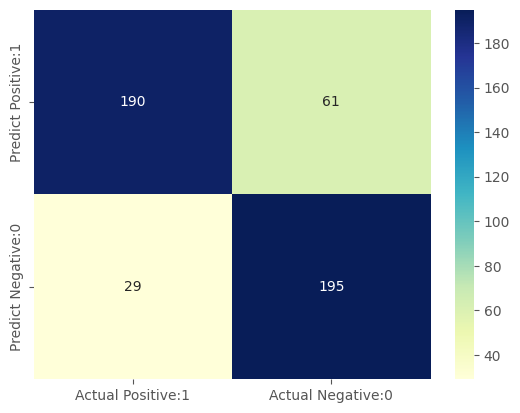

In [357]:
cm = confusion_matrix(y_test, y_pred)

print('Confusion matrix\n\n', cm)

print('\nTrue Positives(TP) [Actual Positive:1 and Predict Positive:1] = ', cm[0,0])
print('\nTrue Negatives(TN) [Actual Negative:0 and Predict Negative:0] = ', cm[1,1])
print('\nFalse Positives(FP) [Actual Negative:0 but Predict Positive:1] = ', cm[0,1])
print('\nFalse Negatives(FN) [Actual Positive:1 but Predict Negative:0] = ', cm[1,0])

print(f'\nThe confusion matrix shows {cm[0,0]} + {cm[1,1]} = {cm[0,0] + cm[1,1]} correct predictions and {cm[0,1]} + {cm[1,0]} = {cm[0,1] + cm[1,0]} incorrect predictions.')

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'],
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

> **Best Model Evaluation Metrics**

In [358]:
TP = cm[0,0]
TN = cm[1,1]
FP = cm[0,1]
FN = cm[1,0]

accuracy = accuracy_score(y_test, y_pred) * 100
precision = precision_score(y_test, y_pred) * 100
specificity = TN / (TN + FP) * 100
recall = recall_score(y_test, y_pred) * 100
f1score = f1_score(y_test,y_pred) * 100

print("Best ANN Accuracy : {0:0.2f}".format(accuracy))
print("Best ANN Precision : {0:0.2f}".format(precision))
print("Best ANN Specificity : {0:0.2f}".format(specificity))
print("Best ANN Recall or Sensitivity : {0:0.2f}".format(recall))
print("Best ANN F1_score : {0:0.2f}".format(f1score))

accuracy_list.append(accuracy)
precision_list.append(precision)
specificity_list.append(specificity)
sensitivity_list.append(recall)
f1score_list.append(f1score)

Best ANN Accuracy : 81.05
Best ANN Precision : 76.17
Best ANN Specificity : 76.17
Best ANN Recall or Sensitivity : 87.05
Best ANN F1_score : 81.25


> **ROC-AUC Analysis**

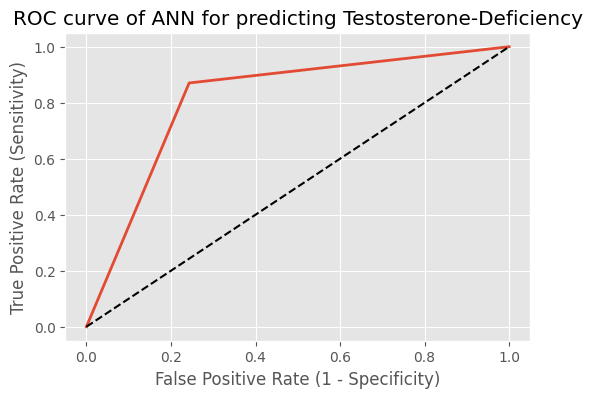

ROC AUC : 0.8138


In [359]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1], [0,1], 'k--' )
plt.rcParams['font.size'] = 10
plt.title('ROC curve of ANN for predicting Testosterone-Deficiency')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

plt.show()

ROC_AUC = roc_auc_score(y_test, y_pred)
print('ROC AUC : {:.4f}'.format(ROC_AUC))
roc_auc_list.append(ROC_AUC)

## 8. Comparison table

In [368]:
data = {
    'Accuracy': accuracy_list,
    'Precision': precision_list,
    'Specificity': specificity_list,
    'Sensitivity': sensitivity_list,
    'F1 Score': f1score_list,
    'ROC AUC': roc_auc_list
}

df = pd.DataFrame(data, index = model_list)
df

,Accuracy,Precision,Specificity,Sensitivity,F1 Score,ROC AUC
SVM,88.619600,92.695214,92.695214,82.326622,87.203791,0.882749
RF,85.879874,84.245077,84.245077,86.129754,85.176991,0.858936
XGB,86.195996,87.264151,87.264151,82.774049,84.959816,0.860085
KNN,80.716544,73.076923,73.076923,93.512304,82.041217,0.814175
ANN,81.052632,76.171875,76.171875,87.053571,81.250000,0.813754


## 9. Saving the model for deployment

In [373]:
print('Saving SVM Model...............')
pickle.dump(best_svc, open('SVM_Model.pkl', 'wb'))

print('Saving RF Model...............')
pickle.dump(best_rf, open('RF_Model.pkl', 'wb'))

print('Saving XGB Model...............')
pickle.dump(best_xgb, open('XGB_Model.pkl', 'wb'))

print('Saving KNN Model...............')
pickle.dump(best_knn, open('KNN_Model.pkl', 'wb'))

print('Saving ANN Model...............')
torch.save(ann.state_dict(), 'ANN_model.pth')

print('Done')

Saving SVM Model...............
Saving RF Model...............
Saving XGB Model...............
Saving KNN Model...............
Saving ANN Model...............
Done
